In [180]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import librosa

In [181]:
def load_force_alignment_result(alignment_path, phones_path):
    alignment = pd.read_csv(alignment_path, sep="\s", names=["file_utt","utt","start","duration","id"], engine='python')
    
    id2phoneme = pd.read_csv(phones_path, sep="\s", names=["phonemes", "id"], engine='python')
    id2phoneme = id2phoneme.set_index(keys="id").to_dict()["phonemes"]
    alignment["phonemes"] = alignment.id.apply(lambda x: id2phoneme[int(x)])
    
    return alignment

alignment_path = "/data/codes/prep_gopt/egs/gop_speechocean762/s5/exp/ali_infer/merged_alignment.txt"
phones_path = "/data/codes/prep_gopt/egs/gop_speechocean762/s5/data/lang_nosp/phones.txt"

alignment = load_force_alignment_result(alignment_path=alignment_path, phones_path=phones_path)
alignment.phonemes = alignment.phonemes.apply(lambda x: x.split(" "))
alignment = alignment.explode(column="phonemes").reset_index()
alignment["pure_phonemes"] = alignment.phonemes.apply(lambda x: x.split("_")[0])
alignment = alignment[alignment.phonemes != "SIL"].reset_index()
alignment.head()

,level_0,index,file_utt,utt,start,duration,id,phonemes,pure_phonemes
0,1,1,audio,1,0.42,0.34,331,W_B,W
1,2,2,audio,1,0.76,0.12,193,IH1_I,IH1
2,3,3,audio,1,0.88,0.14,224,L_E,L
3,4,4,audio,1,1.02,0.10,107,B_B,B
4,5,5,audio,1,1.12,0.17,208,IY1_E,IY1


In [182]:
pd.set_option('mode.chained_assignment', None)
alignment["word_id"] = [-1] * alignment.shape[0]
current_word_id = -1
for index in alignment.index:
    if alignment["phonemes"][index].endswith("_S") or alignment["phonemes"][index].endswith("_B"):
        current_word_id += 1
    alignment["word_id"][index] = current_word_id
    continue
alignment.head()

,level_0,index,file_utt,utt,start,duration,id,phonemes,pure_phonemes,word_id
0,1,1,audio,1,0.42,0.34,331,W_B,W,0
1,2,2,audio,1,0.76,0.12,193,IH1_I,IH1,0
2,3,3,audio,1,0.88,0.14,224,L_E,L,0
3,4,4,audio,1,1.02,0.10,107,B_B,B,1
4,5,5,audio,1,1.12,0.17,208,IY1_E,IY1,1


In [183]:
from dataclasses import dataclass
from typing import List

@dataclass
class Phoneme:
    arpabet: str
    start_time: float
    end_time: float
    score: float
    
    def __init__(self, arpabet, start_time, end_time, score):
        self.arpabet = arpabet
        self.start_time = start_time
        self.end_time = end_time
        self.score = score
    
    def to_dict(self):
        return {
            "arpabet": self.arpabet,
            "start_time": self.start_time,
            "end_time": self.end_time,
            "score": self.score
        }
        
@dataclass
class Word:
    text: str
    arpabet: str
    start_time: float
    phonemes: List[Phoneme]
    end_time: float
    score: float
    
    def __init__(self, text, arpabet, start_time, end_time, score, phonemes):
        self.arpabet = arpabet
        self.text = text
        self.start_time = start_time
        self.end_time = end_time
        self.score = score
        self.phonemes = phonemes
    
    def append_phone(self, phone):
        self.phonemes.append(phone)
    
    def to_dict(self):
        return {
            "arpabet": self.arpabet,
            "phonemes": [phoneme.to_dict() for phoneme in self.phonemes],
            "start_time": self.start_time,
            "end_time": self.end_time,
            "score": self.score
        }

@dataclass
class Sentence:
    arpabet: str
    duration: float
    score: float
    words: List[Word]
    
    def __init__(self, arpabet, duration, score, words):
        self.arpabet = arpabet
        self.duration = duration
        self.score = score
        self.words = words
        
    def append_word(self, word):
        self.words.append(word)
    
    def append_phoneme(self, word_index, phoneme):
        self.words[word_index].append_phone(phoneme)
        self.words[word_index].end_time = phoneme.end_time 
    
    def to_dict(self):
        return {
            "arpabet": self.arpabet,
            "duration": self.duration,
            "phonemes": [word.to_dict() for word in self.words],
            "score": self.score
        }


In [184]:
def parse_score(transcript):
    words = transcript.split(" ")
    _tmp_word = Word(
        text=words[0], 
        arpabet=None,
        score=None, 
        end_time=0, 
        start_time=0, 
        phonemes=[]
    )
    
    utterance = Sentence(
        arpabet=None, 
        score=None, 
        duration=0.0, 
        words=[],
    )

    curr_word_id = -1
    for index in range(alignment.shape[0]):
        word_id = int(alignment["word_id"][index])
        start_time = alignment["start"][index]
        end_time = start_time + alignment["duration"][index]
        
        _tmp_phone = Phoneme(
            arpabet="None",
            end_time=end_time, start_time=start_time,
            score=None
        )

        if word_id == curr_word_id:
            utterance.append_phoneme(word_index=word_id, phoneme=_tmp_phone)
        else:
            _tmp_word = Word(
                arpabet=None, start_time=_tmp_phone.start_time, end_time=_tmp_phone.end_time, text=words[word_id],
                score=None, phonemes=[_tmp_phone, ]
            )
            if len(utterance.words) == word_id:
                utterance.append_word(_tmp_word)
            else:
                utterance.append_phoneme(word_index=word_id, phoneme=_tmp_phone)
    return utterance

# text = "IN TRUTH SHE SEEMED ABSOLUTELY HIDDEN BEHIND IT"
text = "HE WILL BE MAKING A NEW SCULPTURE FOR THE EXHIBITION"

utterance = parse_score(transcript=text)

In [185]:
# import soundfile as sf
# import librosa
# path = "/data/asr_dataset/LibriSpeech/test-clean/1221/135767/1221-135767-0020.flac"
# waveform, sr = librosa.load(path, sr=16000)

# sf.write("/data/codes/prep_gopt/1221-135767-0020.wav", waveform, sr)

In [186]:
# path = "/data/asr_dataset/LibriSpeech/test-clean/237/126133/237-126133-0013.flac"
# text = "I KNOW GASPED POLLY CONTROLLING HER SOBS I WON'T ONLY I CAN'T THANK YOU"
# waveform, sample_rate = librosa.load(path, sr=16000)

In [187]:
# "He will be making a new sculpture for the exhibition".upper()

In [188]:
path = "/data/codes/prep_gopt/audio.wav"
waveform, sample_rate = librosa.load(path, sr=16000)

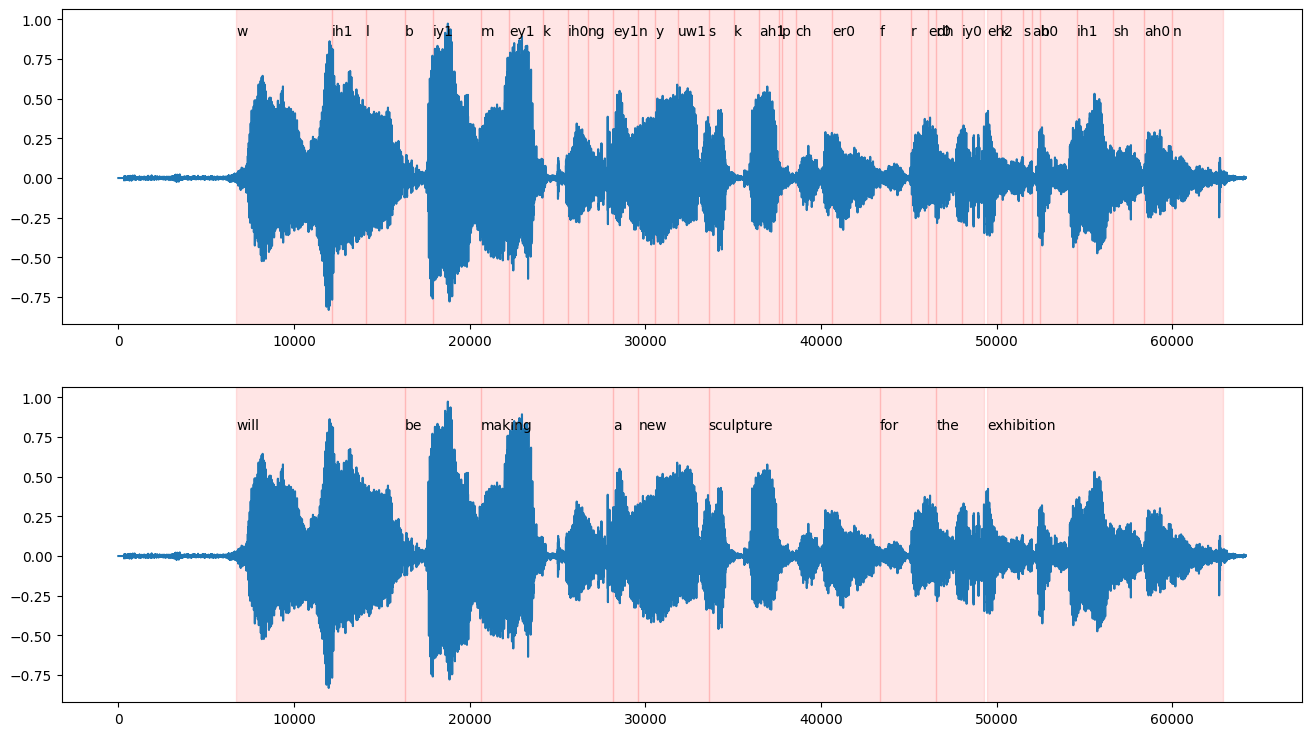

In [189]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 9))
ax1.plot(waveform)
ratio = 16000
for index in alignment.index:
    start_time = alignment["start"][index]
    end_time = start_time + alignment["duration"][index]
    x0 = ratio * start_time
    x1 = ratio * end_time
    
    phoneme = alignment["pure_phonemes"][index]
    ax1.axvspan(x0, x1, alpha=0.1, color="red")
    ax1.annotate(f"{phoneme.lower()}", (x0, 0.9), )
    
ax2.plot(waveform)

for word in utterance.words:
    start_time = word.start_time
    end_time = word.end_time
    text = word.text
    
    x0 = ratio * start_time
    x1 = ratio * end_time
    
    ax2.axvspan(x0, x1, alpha=0.1, color="red")
    ax2.annotate(f"{text.lower()}", (x0, 0.8))#, ha='left', rotation=30)

